## Part 2 – Analyzing the simulated data

Now that we have our simulated data in a format very similar to what we would expect in a real experiment, we can start analyzing this data. 
 
### Loading the data from part 1

In [100]:
import numpy as np
from matplotlib import pyplot as plt

[spktimes,stim_type,stim_times,srate] = np.load('simulated_data1.npy',allow_pickle=True)

First we can extract the number spikes per some unit of time for each cell, and organize this data into different trials. We are going to use bins of 100 ms with no overlap, going from 1 s before the start of each stimulus and to 3 s after it. Our resultant structure is a N by T by B spike count matrix, where N is the number of neurons (20), T is the number of trials (100) and B is the number of bins (40, in this case).

In [27]:
binwidth = 0.1 # in seconds (100 ms)
bins = np.arange(0,4*srate+binwidth*srate,binwidth*srate)
        
bins=bins/srate

n_cells=len(spktimes)
n_trials= len(stim_type)

spk_matrix = np.zeros((n_cells,n_trials,len(bins)-1))

for icell in np.arange(n_cells):
    
    spk = spktimes[icell]
    
    for itrial in np.arange(n_trials):
        idx = np.where(np.logical_and(spk>stim_times[itrial]-1, spk<=stim_times[itrial]+3))[0]
        
        spk_temp = spk[idx]-(stim_times[itrial]-1)
        
        count = np.histogram(spk_temp,bins)
        
        spk_matrix[icell,itrial, :] = count[0]

        
# let's define our time vector as the center of each bin
time_bins = bins[0:-1]+binwidth/2

# we also want the time 0 to be the moment of the stimulus
time_bins = time_bins -1

Plotting an example neuron
Let's see the activity of one neuron across the time bins for different trials. Find a neuron in which you can clearly see the simulus modulation.

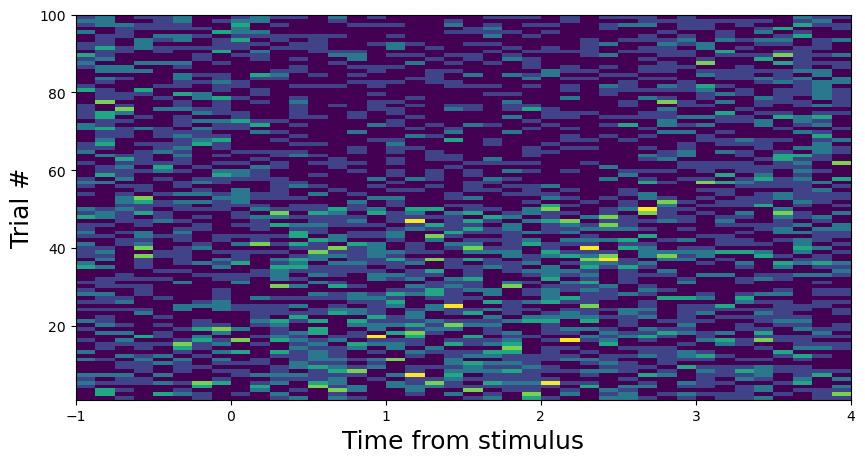

In [50]:

ineuron=5

plt.figure(1,(10,5))
plt.imshow(np.squeeze(spk_matrix[ineuron,:,:]), extent = [-1, 4, 1, n_trials],vmin=0,vmax=5, aspect='auto')
plt.xlabel('Time from stimulus',fontsize=18)
plt.ylabel('Trial #',fontsize=18)
plt.show()

## Creating a SVM classifier

With the activity of all the neurons separated in trials and time bins, we can now start training our SVM classifier. 

However, before going further, it is important to discuss two different sources of error in classification problems: the bias and the variance. 

Bias error arises from wrong assumptions made by the classifier, or limitations to extract the underlying relations between features of the data (e.g., underfitting). On the other hand, variance error arises from the variability of performance introduced by the sensitivity of the set of samples used to train the classifier (e.g., overfitting). 

We are going to see later a way of dealing with the bias. For now, we are going to use cross-validation to avoid overfitting. Cross validation consists in using different sets for training and testing, so that you don't risk creating a model that is overfitted to your sample. 

A simple way to do this is to use a K-fold crossvalidation scheeme. This consists in dividing your samples into K disjoints sets, and train K different models, separating, in each of them, a different set to test (and use the others sets to train). 

A common value for K is 10, but to simplify our computations we are going to use K=2.

In [85]:
# from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn import svm

In [93]:
ibin=10 # try ibin= 9, 10, 11
performance=[];

# separating the activity of our bin of interest
bin_matrix = np.squeeze(spk_matrix[:,:,ibin]);


# setting the 2-fold crossvalidation
k=2

skf = StratifiedKFold(n_splits=k, shuffle=True)

# creating 2 disjoints sets of indexes
for train,test in skf.split(bin_matrix.T,stim_type):
    
    # create a svm Classifier
    svm_classifier = svm.SVC(kernel='linear') # Linear Kernel

    # training the model using the training sets
    svm_classifier.fit(bin_matrix[:,train].T, stim_type[train])

    # predicting the stimulus type for test dataset
    predicted_type = svm_classifier.predict(bin_matrix[:,test].T)
    
    performance.append(np.mean(predicted_type==stim_type[test]))

In [94]:
performance

[0.88, 0.88]

The performance is then computed as the mean performance over the K-folds.


In [95]:
mean_performance  = np.mean(performance)

### Excersice 1
Calculate the mean performance for all the time bins and make a plot of mean performance vs time from the stimulus.

### Exercise 2
Explore different settings of the variable modulation (i.e., try to change the std of the distribution from which the its drawn). Compare the plot in Exercise 1 for each modulation value. What happens to the mean performance when you increase or decrease the std? 

Try to reason an explanation for the results you found. (Hint: try values like 0.1, 0.5 and 2).

### Assessing statistical significance with surrogates

Looking at the figure generated in question 1 we can see that, although there is no information about the stimulus in the first second of our trial, we can still see some fluctuations. How do we determine if each value is significantly above chance?

One way to do it is to try to 'destroy' any information about the stimulus type present in our data and see how high is this 'radom' performance. In fact, if we repeat this procedure multiple times, we can get a distribution of this 'radom' performance. This is called what we call a surrogate distribution. Let's implement it for two example timebins (bins 1 and 20).

We can start considering only one bin. In our case, bin 1. The following code computes the mean performance using a 2-fold crossvalidation.

In [ ]:

ibin=1
performance=[];

# separating the activity of our bin of interest
bin_matrix = np.squeeze(spk_matrix[:,:,ibin]);


# setting the 2-fold crossvalidation
k=2

skf = StratifiedKFold(n_splits=k, shuffle=True)

# creating 2 disjoints sets of indexes
for train,test in skf.split(bin_matrix.T,stim_type):
    
    # create a svm Classifier
    svm_classifier = svm.SVC(kernel='linear') # Linear Kernel

    # training the model using the training sets
    svm_classifier.fit(bin_matrix[:,train].T, stim_type[train])

    # predicting the stimulus type for test dataset
    predicted_type = svm_classifier.predict(bin_matrix[:,test].T)
    
    performance.append(np.mean(predicted_type==stim_type[test]))
    
mean_performance  = np.mean(performance)




Now computing the surrogates:


In [163]:
import random

In [159]:
n_surr = 100
mean_surr_performance=np.zeros(n_surr)

for isurr in np.arange(n_surr):
    performance=[]
    # and then we use the shuffled stim_type vector to train the SVM
    for train,test in skf.split(bin_matrix.T,stim_type):
        
        # For each surrogate let's randomly shuffle the training stim_type.
        stim_type_shuff = stim_type[train].copy()
        random.shuffle(stim_type_shuff)
#         print(stim_type_shuff-stim_type[train])
        
        
        # create a svm Classifier
        svm_classifier = svm.SVC(kernel='linear') # Linear Kernel

        # training the model using the training sets
        svm_classifier.fit(bin_matrix[:,train].T, stim_type_shuff)
        
        # predicting the stimulus type for test dataset
        predicted_type = svm_classifier.predict(bin_matrix[:,test].T)
        
        performance.append(np.mean(predicted_type==stim_type[test]))
        
    mean_surr_performance[isurr]  = np.mean(performance)

Ploting the surrogate distribution and the real performance

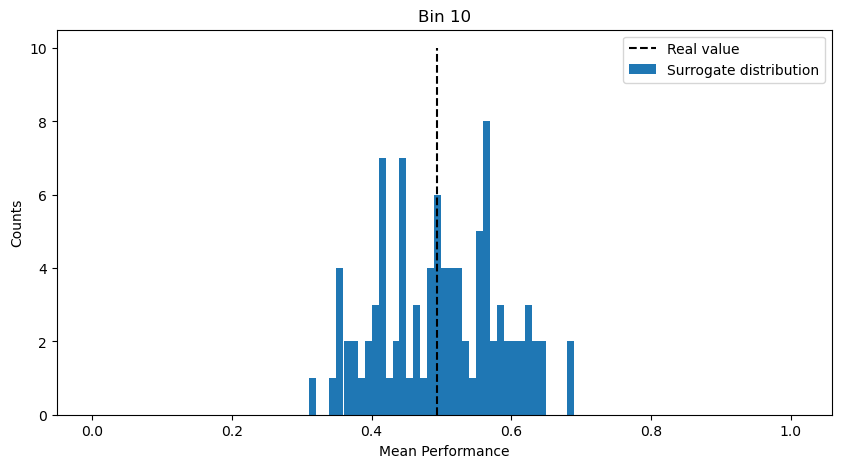

In [161]:
plt.figure(figsize=(10, 5))

bins = np.arange(0,1+0.001,0.001)
bins_center = bins[:-1]+0.005

count = np.histogram(mean_surr_performance,bins)[0]
plt.bar(bins_center,count,0.01)

plt.vlines(mean_performance,0,10,colors='k',linestyles='dashed')
plt.xlabel('Mean Performance')
plt.ylabel('Counts')
plt.title('Bin ' + str(ibin))
plt.legend({'Surrogate distribution', 'Real value'})
plt.show()


Now let's do the same for bin 15:

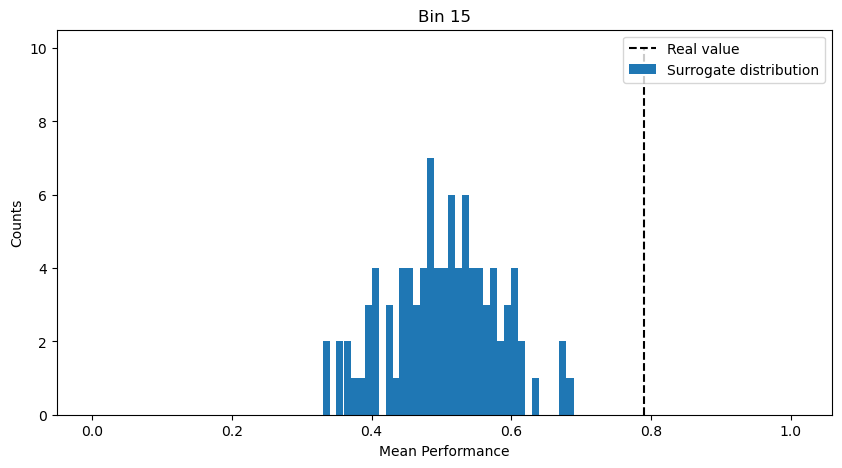

In [162]:

ibin=15
performance=[];

# separating the activity of our bin of interest
bin_matrix = np.squeeze(spk_matrix[:,:,ibin]);


# setting the 2-fold crossvalidation
k=2

skf = StratifiedKFold(n_splits=k, shuffle=True)

# creating 2 disjoints sets of indexes
for train,test in skf.split(bin_matrix.T,stim_type):
    
    # create a svm Classifier
    svm_classifier = svm.SVC(kernel='linear') # Linear Kernel

    # training the model using the training sets
    svm_classifier.fit(bin_matrix[:,train].T, stim_type[train])

    # predicting the stimulus type for test dataset
    predicted_type = svm_classifier.predict(bin_matrix[:,test].T)
    
    performance.append(np.mean(predicted_type==stim_type[test]))
    
mean_performance  = np.mean(performance)

n_surr = 100
mean_surr_performance=np.zeros(n_surr)

for isurr in np.arange(n_surr):
    performance=[]
    # and then we use the shuffled stim_type vector to train the SVM
    for train,test in skf.split(bin_matrix.T,stim_type):
        
        # For each surrogate let's randomly shuffle the training stim_type.
        stim_type_shuff = stim_type[train].copy()
        random.shuffle(stim_type_shuff)
#         print(stim_type_shuff-stim_type[train])
        
        
        # create a svm Classifier
        svm_classifier = svm.SVC(kernel='linear') # Linear Kernel

        # training the model using the training sets
        svm_classifier.fit(bin_matrix[:,train].T, stim_type_shuff)
        
        # predicting the stimulus type for test dataset
        predicted_type = svm_classifier.predict(bin_matrix[:,test].T)
        
        performance.append(np.mean(predicted_type==stim_type[test]))
        
    mean_surr_performance[isurr]  = np.mean(performance)
    
plt.figure(figsize=(10, 5))

bins = np.arange(0,1+0.001,0.001)
bins_center = bins[:-1]+0.005

count = np.histogram(mean_surr_performance,bins)[0]
plt.bar(bins_center,count,0.01)

plt.vlines(mean_performance,0,10,colors='k',linestyles='dashed')
plt.xlabel('Mean Performance')
plt.ylabel('Counts')
plt.title('Bin ' + str(ibin))
plt.legend({'Surrogate distribution', 'Real value'})
plt.show()


So now we have a surrogate distribution of performance along with the real performance for bin 1 and 15. Note that bin 1 has a real value really close to the mean of the surrogate distribution, while bin 15 has a far higher value than the rest of the distribution.

In fact, the mean of the surrogate distribution is an estimate of the bias of our classifier. Note that we can have different surrogate distributions for different timebins because they have different firing rate across the neurons. Now that we have surrogate distributions we can then think in a way of using it to normalize the real values, so that we can easily compare bins with diferent biases. For that, we are going to use the mean and the standard deviation (std) of the surrogates (Exercise 3).


### Exercise 3

Replot the graphs in the previous cells normalizing the distribution and the real performance  by the mean  and the std  of the surrogates using a Z-score transformation:

$$
    P_{norm} = \frac{P - \mu}{\sigma}
$$

This means that the x-axis will measure how far the real value is from the mean in units of standard deviations. (Hint: the bins used to compute the histogram will be different after the transformation)


### Exercise 4
Repeat the plot in Exercise 1 using the the z-scored values computed in the previous section. Also plot for each bin the maximum value of the (z-scored) surrogate distribution.


One important thing to notice here is that we can extract a significance value out of the surrogate distribution. In our case, because we only did 100 surrogates, the maximum surrogate value correspond to 1% of the distribution. So, if our real value is higher than this 1%, we can say that we have a p-value of p<0.01 (1%). In other words, if there is no information of the stimulus in the activity, and we repeat this experiment 100 times, we would have a spurious performance value higher than our real value in less than 1% of the times. That is what p<0.01 means.

Notice that if we increase the number of surrogates to 1000, for example, the threshold for p<0.01 would not be in the maximum value of the surrogate (that would be the 0.1%), but in the 10th higher value. 

Finally, we can also think in the reverse way. We can look into the rank of our real value in the surrogate distribution and extract an 'exact' p-value. For example, if our real value is the higher than the 97% of the surrogate distribution, we can say it has p=0.03.